# Basic Q-Learning task

In [2]:
# imports
import numpy as np
from helpers.map import basic_map
from helpers.get_available_actions import get_available_actions
from helpers.q_matrix import q_matrix
from helpers.r_matrix import r_matrix
from helpers.random_start import random_start
from helpers.states_and_actions import states
import pandas as pd
from IPython.display import display
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
from functools import partial
from multiprocessing import Pool

## Graph of Environment

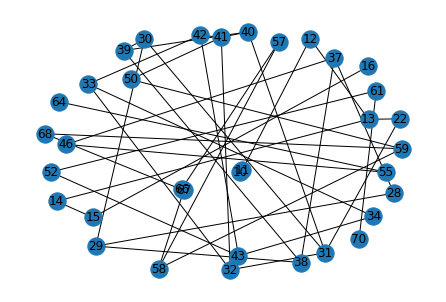

In [3]:
# using https://networkx.org/documentation/stable/tutorial.html
# initialise the graph
G = nx.Graph()

# Get the R Matrix to tell which states connect to other states
r = r_matrix(basic_map())

# check whether the state has access to anythere and if it does then add it. Otherwise don't (this cuts down on the number of nodes)
ns = [y for y, row in enumerate(r) if len(get_available_actions(r, y)) > 0]
G.add_nodes_from(ns)

# start iterating through the R matrix to get the connections
for y, row in enumerate(r):
    for x, cellweight in enumerate(row):
        # if the cell isn't null add the edge and the weight
        if not np.isnan(cellweight):
            G.add_edge(y, x, weight=cellweight)

# draw the graph
nx.draw(G, with_labels=True)

# Remove the variables
del r
del G

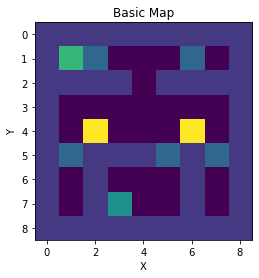

In [4]:
# Here we use imshow to show the basic map and label the axes
plt.imshow(basic_map())
plt.title('Basic Map')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

## Initialise basic environment

In [5]:
def run_q_learning_basic(alpha: float, gamma: float, epsilon: float, num_episodes: int, 
    show_stats=True, base_map=basic_map(), S=states(basic_map()), goal_state=10, 
    rmat=r_matrix(basic_map()), convergence_check_episodes=10, convergence_threshold=0.01) -> dict:
    """Here we run an episode of Q-learning for the learner
    heavily influenced by Lab 4 code
    
    As it has a primary and secondary objective, I may need to stop it from repeatedly collecting the 1st reward.
    
    I have moved the map and states definitions out of the function as they don't change within it and in theory that should map it faster. The q matrix gets reset each time"""
    
    #base_map = basic_map()
    
    # States and actions
    #S = states(base_map)
    
    #goal_state = 10#66# 10 # TODO get programatically
    
    # R matrix
    #rmat = r_matrix(base_map)
    
    # Q matrix
    Q = q_matrix(base_map)

    # Fixing random state
    local_state = np.random.RandomState() # from https://stackoverflow.com/questions/29854398/seeding-random-number-generators-in-parallel-programs
    
    # Stats
    stats = {
        'num_steps': [],
        'stepPrimaryObj': [],
        'startingStep': [],
        'maxQ': [],
        'total_reward': [],
        'total_health': [],
        'q_var': []
    }
    
    # run for episodes
    for episode in range(num_episodes):
        s = random_start(base_map)
        #print(f"Starting state is {s}")
        hit_target = False
        stats['startingStep'].append(s)
        total_reward = 0
        total_health = 100
        for step in range(500):
            potential_actions = get_available_actions(rmat, s)
            
            # get the Q values for these
            q_values = [Q[s, a] for a in potential_actions]
            
            # get the best actions from the Q values
            max_q = np.max(q_values) # pre calculate ahead of the loop
            best_actions = potential_actions[np.where(q_values == max_q)[0]]
            # get the best actions Q values
            # best_actions_q_values = [Q[s, x] for x in best_actions]
            
            # determine whether to explore or exploit
            if local_state.uniform() > epsilon:
                a = local_state.choice(potential_actions)
            else:
                a = local_state.choice(best_actions)
        
            # Get the reward
            reward = rmat[s, a]
            if reward == 50:
                if hit_target:
                    reward = 0
                else:
                    hit_target = True
                    stats['stepPrimaryObj'].append(step)
            elif reward == -10:
                # Check if it hit a trap
                total_health -= 10
            
            old_state = s
            s = a
            
            total_reward += reward

            # Update Q Value
            Q[old_state, a] = Q[old_state, a] + alpha * reward + gamma * (max(Q[s]) - Q[old_state, a])
            
            # check if goal reached
            if S[s] == goal_state or total_health <= 0:
                # print("Hit goal!")
                break
        # start filling in the statistics
        stats['num_steps'].append(step + 1)
        if not hit_target:
            stats['stepPrimaryObj'].append(-1)
        # cap the Q values statistics decimal places
        stats['maxQ'].append(Q.max().round(1))
        stats['total_reward'].append(total_reward)
        stats['total_health'].append(total_health)
        stats['q_var'].append(Q.var())

        # Early stopping
        # if Q's variance has stayed the same for 10 episodes then assume it has converged
        if episode > convergence_check_episodes and np.var(stats['q_var'][-1 * convergence_check_episodes:]) < convergence_threshold:
            break
    
    if show_stats:
        #print(f"End of episode {episode} Q matrix:\n{Q.round(1)}")
        display(pd.DataFrame(Q.round(1)))
        # put the statistics using pandas
        display(pd.DataFrame.from_dict(stats))

    # return the statistics
    return {
        'alpha': alpha,
        'gamma': gamma,
        'epsilon': epsilon,
        'mean_reward': np.mean(stats['total_reward']), # don't cast the types
        'mean_total_health': np.mean(stats['total_health']),
        'q_var': Q.mean(), # don't take the variance of the variance, take the mean
        'num_episodes': episode + 1 # The episodes until convergence
    }
run_q_learning_basic(1, 0.8, 0.9, 1000)

,0,1,2,3,4,5,6,7,8,9,...,71,72,73,74,75,76,77,78,79,80
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
77,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
78,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,num_steps,stepPrimaryObj,startingStep,maxQ,total_reward,total_health,q_var
0,218,79,22,30.0,10.0,30,4.246876e-01
1,500,2,57,30.9,50.0,100,1.711619e+00
2,500,181,22,46.1,30.0,80,4.121769e+00
3,500,60,57,61.4,50.0,100,7.467843e+00
4,54,-1,70,61.4,20.0,90,7.615209e+00
...,...,...,...,...,...,...,...
995,500,8,61,36383.9,40.0,90,1.222603e+07
996,500,8,33,36425.5,50.0,100,1.223797e+07
997,500,6,43,36467.2,40.0,90,1.224739e+07
998,500,3,68,36508.9,50.0,100,1.225241e+07


{'alpha': 1,
 'gamma': 0.8,
 'epsilon': 0.9,
 'mean_reward': 45.75,
 'mean_total_health': 96.89,
 'q_var': 377.9426438978455,
 'num_episodes': 1000}

In [6]:
# Grid search
def run_q_learning_basic_tuple(alpha_gamma_epsilon, num_episodes, base_map=None, S=None, rmat=None, convergence_check_episodes=10, convergence_threshold=0.01):
    """Run run_q_learning from a tuple for the map call"""
    a, g, e = alpha_gamma_epsilon
    return run_q_learning_basic(a, g, e, num_episodes=num_episodes, show_stats=False, base_map=base_map, S=S, convergence_check_episodes=convergence_check_episodes, convergence_threshold=convergence_threshold)

alphas = [0.0, 0.5, 1.0]
gammas = [0.7, 0.8, 0.9]
epsilons = [0.7, 0.8, 0.9]
def grid_search(alphas: list, gammas: list, epsilons: list, num_episodes=1000, convergence_check_episodes=10, convergence_threshold=0.01) -> pd.DataFrame:
    """Here we loop through all of the alphas, gammas and epsilons for the function and return the concatenated returns from the function"""
    # Build a dictionary to hold the results
    #ret = {
    #    'alpha': [],
    #    'gamma': [],
    #    'epsilon': [],
    #    'mean_reward': [],
    #    'mean_total_health': [],
    #    'q_var': []
    #}
    # start looping
    #for a in alphas:
    #    for g in gammas:
    #        for e in epsilons:
    # go through all of the combinations of values, unpacking the tuples
    
    #for a, g, e in [(a, g, e) for a in alphas for g in gammas for e in epsilons]:
    #    # call the function and then pull out the results
    #    d = fn(a, g, e, num_episodes, show_stats=False)
    #    for k, v in d.items():
    #        ret[k].append(v)
    # use map to parallelise going through the iterations
    
    # create the map
    base_map = basic_map()
    
    # States and actions
    S = states(base_map)

    # R matrix
    rmat = r_matrix(base_map)
    # map the key-word arguments to the Q-learning function
    func = partial(run_q_learning_basic_tuple, num_episodes=num_episodes, base_map=base_map, S=S, rmat=rmat, convergence_check_episodes=convergence_check_episodes, convergence_threshold=convergence_threshold) # from https://stackoverflow.com/questions/13499824/using-map-function-with-keyword-arguments
    # map through each iteration of the different combinations
    # using the multiprocessing Pool version cuts the execution time from ~9 mins to ~2 mins
    with Pool() as p: # from https://docs.python.org/3/library/multiprocessing.html#multiprocessing.pool.Pool
        output = list(p.map(
            #lambda x: run_q_learning_basic(x[0], x[1], x[2], num_episodes=num_episodes, show_stats=False),
            func,
            [(a, g, e) for a in alphas for g in gammas for e in epsilons]
        ))
    # convert the results to a dataframe
    #return pd.DataFrame.from_dict(ret)
    return pd.DataFrame(output)
grid_search(alphas, gammas, epsilons, num_episodes=20)

,alpha,gamma,epsilon,mean_reward,mean_total_health,q_var,num_episodes
0,0.0,0.7,0.7,-34.166667,35.833333,0.000000,12
1,0.0,0.7,0.8,-45.000000,21.666667,0.000000,12
2,0.0,0.7,0.9,-34.166667,34.166667,0.000000,12
3,0.0,0.8,0.7,-34.166667,25.833333,0.000000,12
4,0.0,0.8,0.8,-65.000000,9.166667,0.000000,12
5,0.0,0.8,0.9,-44.166667,25.000000,0.000000,12
6,0.0,0.9,0.7,-55.000000,26.666667,0.000000,12
7,0.0,0.9,0.8,-66.666667,7.500000,0.000000,12
8,0.0,0.9,0.9,-50.833333,30.833333,0.000000,12
9,0.5,0.7,0.7,33.000000,88.500000,0.753131,20


In [39]:
# Use the grid search to repeatedly run the same values
df = grid_search([1.,1.,1.], [0.8,0.8,0.8], [0.9,0.9,0.9])
df

,alpha,gamma,epsilon,mean_reward,mean_total_health,q_var,num_episodes
0,1.0,0.8,0.9,48.720000,99.400000,371.267320,1000
1,1.0,0.8,0.9,45.820000,99.480000,303.713861,1000
2,1.0,0.8,0.9,49.330000,99.370000,406.278219,1000
3,1.0,0.8,0.9,45.480000,99.500000,265.396383,1000
4,1.0,0.8,0.9,48.550000,99.470000,371.539042,1000
5,1.0,0.8,0.9,46.850000,99.470000,333.777993,1000
6,1.0,0.8,0.9,32.539683,98.730159,1.231849,126
7,1.0,0.8,0.9,39.320000,96.510000,214.615584,1000
8,1.0,0.8,0.9,47.350000,97.370000,417.946645,1000
9,1.0,0.8,0.9,47.930000,99.400000,385.072612,1000


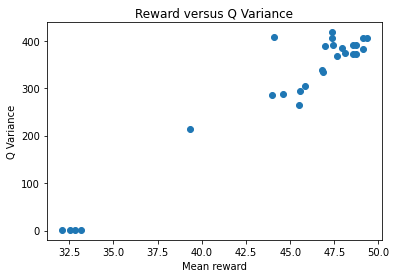

In [40]:
# Here we graphically display the output of the Q function
plt.scatter('mean_reward', 'q_var', data=df) # trick from DataCamp to add the dataframe
plt.xlabel("Mean reward")
plt.ylabel("Q Variance")
plt.title("Reward versus Q Variance")
plt.show()

### Repeat using different parameter values, and policies

,alpha,gamma,epsilon,mean_reward,mean_total_health,q_var,num_episodes
0,0.8,0.8,0.4,18.92,69.70,386.334365,1000
1,0.8,0.8,0.4,18.03,69.11,380.258623,1000
2,0.8,0.8,0.4,17.85,68.87,387.093522,1000
3,0.8,0.8,0.4,17.55,68.47,383.073599,1000
4,0.8,0.8,0.4,17.63,68.56,382.800007,1000
5,0.8,0.8,0.4,17.58,68.76,379.157672,1000
6,0.8,0.8,0.4,17.13,68.06,385.787207,1000
7,0.8,0.8,0.4,18.41,69.52,375.568519,1000
8,0.8,0.8,0.4,18.48,69.21,379.809655,1000
9,0.8,0.8,0.4,18.12,68.89,384.229696,1000


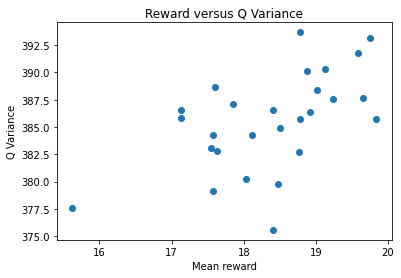

In [10]:
# Grid search on the new parameters to repeatedly show them
# df2 = grid_search([.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.], [.1,.2,.3,.4,.5,.6,.7,.8,.9,1.], [0.1,.2,.3,.4,.5,.6,.7,.8,.9,1.])
# df2 = grid_search([.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.], [.8, .8, .8], [0.4, 0.4, 0.4])
df2 = grid_search([.8, .8, .8], [.8, .8, .8], [.4, .4, .4])
display(df2)
# Here we graphically display the output of the Q function
plt.scatter('mean_reward', 'q_var', data=df2)
plt.xlabel("Mean reward")
plt.ylabel("Q Variance")
plt.title("Reward versus Q Variance")
plt.show()

In [11]:
df2.to_csv("data/NewValues.csv")